# Data Preparation

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import concat
from numpy import concatenate
import numpy as np
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

In [7]:
#load dataset
df = pd.read_csv('D:/AirQualityUCI.csv', parse_dates={'dt': ['Date', 'Time']}, 
                 index_col=0,
                infer_datetime_format=True,
                na_values=['nan','?'])
# fill all missing value (NaN) with 0
df.fillna(0, inplace=True)
# drop temp, RH, and AH
df.drop(['T', 'RH', 'AH'], axis=1, inplace=True)
# drop the first 24 hours
df = df[24:]
# save to new csv file
df.to_csv('D:/AirPollution.csv')   

In [8]:
# load new dataset
data = pd.read_csv('D:/AirPollution.csv', index_col= 0)
values = data.values
display(data.head())

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
dt,,,,,,,,,,
2004-11-03 18:00:00,4.8,1581,307,20.8,1319,281,799,151,2083,1409
2004-11-03 19:00:00,6.9,1776,461,27.4,1488,383,702,172,2333,1704
2004-11-03 20:00:00,6.1,1640,401,24.0,1404,351,743,165,2191,1654
2004-11-03 21:00:00,3.9,1313,197,12.8,1076,240,957,136,1707,1285
2004-11-03 22:00:00,1.5,965,61,4.7,749,94,1325,85,1333,821


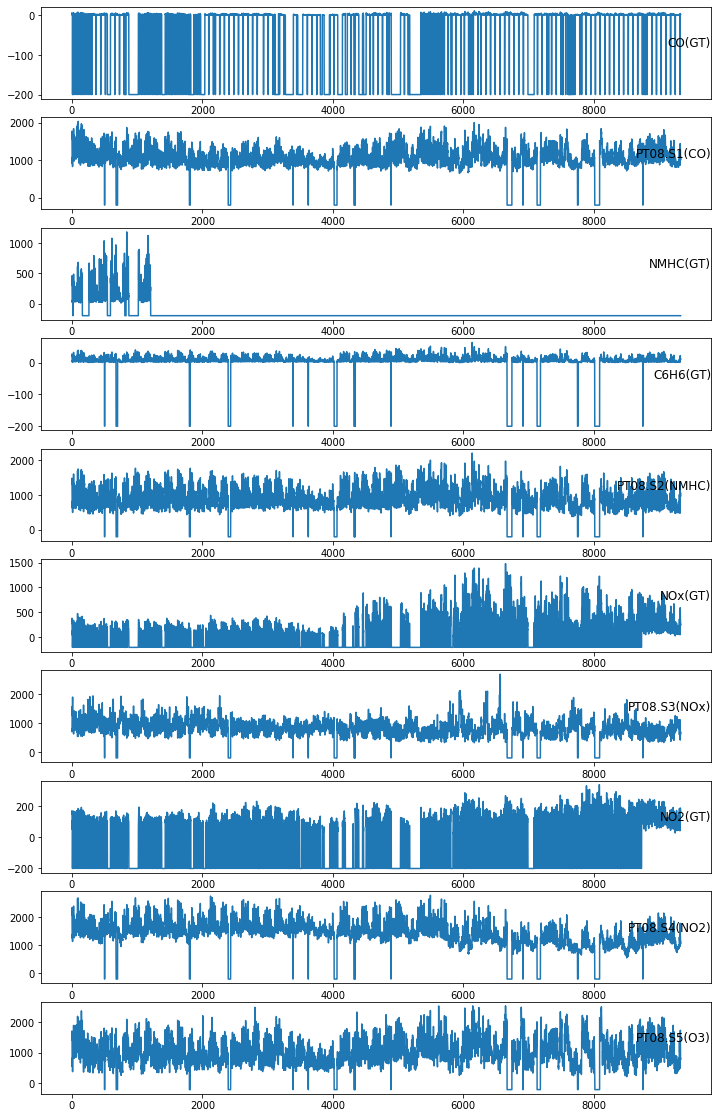

In [9]:
# plotting each column
plt.figure(figsize=(12,20))
# forth column = cbwd (wind direction) -> is str and can not be plot
groups = [0,1,2,3,4,5,6,7,8,9]
i = 1
for g in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, g])
    plt.title(data.columns[g], y=0.5, loc='right')
    i += 1
plt.show()

In [10]:
# convert series to supervised learning
def create_ts_data(data, lookback=1, predicted_col=1):
    temp=data.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=data.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    
    return final_df

In [13]:
# to convert all values to float
values = values.astype('float32')

# normalize values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [15]:
# frame as supervised learning
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 
                       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)','var1(t)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    0.966494   0.795089   0.365011   0.837315   0.629246   0.286480   
2    0.976404   0.882143   0.475882   0.862344   0.699254   0.347230   
3    0.972629   0.821429   0.432685   0.849450   0.664457   0.328172   
4    0.962246   0.675446   0.285817   0.806978   0.528583   0.262061   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
id                                                         
1    0.346514   0.650000   0.767395    0.590892  0.976404  
2    0.312869   0.688889   0.851429    0.699229  0.972629  
3    0.327090   0.675926   0.803697    0.680867  0.962246  
4    0.401318   0.622222   0.641008    0.545354  0.950920  


# Set LSTM model

In [16]:
# Split train and test data
values = reframed_df.values
# number of hour
training_sample = 365 * 24
train = values[:training_sample, :]
test = values[training_sample:, :]
X_train, Y_train = train[:, :-1], train[:, -1]
X_test, Y_test = test[:, :-1], test[:, -1]

In [17]:
# reshape input to be 3D [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(8760, 1, 10) (8760,) (572, 1, 10) (572,)


In [18]:
# define and compile LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             25800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 30)             12720     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 45,871
Trainable params: 45,871
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit the model
history_lstm = model_lstm.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), shuffle=False)


Train on 8760 samples, validate on 572 samples
Epoch 1/10
8760/8760 [==============================] - 3s 295us/step - loss: 0.3599 - val_loss: 0.0698
Epoch 2/10
8760/8760 [==============================] - 1s 147us/step - loss: 0.1367 - val_loss: 0.0509
Epoch 3/10
8760/8760 [==============================] - 1s 151us/step - loss: 0.0869 - val_loss: 0.0814
Epoch 4/10
8760/8760 [==============================] - 1s 154us/step - loss: 0.0730 - val_loss: 0.0457
Epoch 5/10
8760/8760 [==============================] - 1s 152us/step - loss: 0.0637 - val_loss: 0.0440
Epoch 6/10
8760/8760 [==============================] - 1s 143us/step - loss: 0.0601 - val_loss: 0.0416
Epoch 7/10
8760/8760 [==============================] - 1s 145us/step - loss: 0.0529 - val_loss: 0.0399
Epoch 8/10
8760/8760 [==============================] - 1s 151us/step - loss: 0.0518 - val_loss: 0.0392
Epoch 9/10
8760/8760 [==============================] - 1s 144us/step - loss: 0.0499 - val_loss: 0.0386
Epoch 10/10
8760

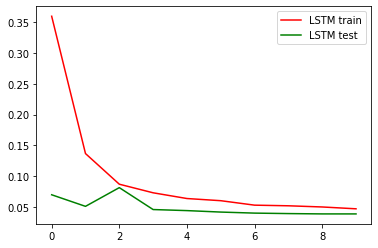

In [20]:
plt.plot(history_lstm.history['loss'], label='LSTM train', color='red')
plt.plot(history_lstm.history['val_loss'], label='LSTM test', color= 'green')
plt.legend()
plt.show()

# Set GRU model

In [21]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))
model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 75)             19350     
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 30)             9540      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 34,411
Trainable params: 34,411
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit the model
gru_history = model_gru.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), shuffle=False)

Train on 8760 samples, validate on 572 samples
Epoch 1/10
8760/8760 [==============================] - 3s 318us/step - loss: 0.2448 - val_loss: 0.0439
Epoch 2/10
8760/8760 [==============================] - 1s 166us/step - loss: 0.0829 - val_loss: 0.0463
Epoch 3/10
8760/8760 [==============================] - 1s 164us/step - loss: 0.0620 - val_loss: 0.0431
Epoch 4/10
8760/8760 [==============================] - 1s 162us/step - loss: 0.0562 - val_loss: 0.0375
Epoch 5/10
8760/8760 [==============================] - 1s 166us/step - loss: 0.0566 - val_loss: 0.0375
Epoch 6/10
8760/8760 [==============================] - 1s 163us/step - loss: 0.0529 - val_loss: 0.0459
Epoch 7/10
8760/8760 [==============================] - 1s 164us/step - loss: 0.0528 - val_loss: 0.0384
Epoch 8/10
8760/8760 [==============================] - 1s 167us/step - loss: 0.0497 - val_loss: 0.0374
Epoch 9/10
8760/8760 [==============================] - 2s 172us/step - loss: 0.0462 - val_loss: 0.0364
Epoch 10/10
8760/

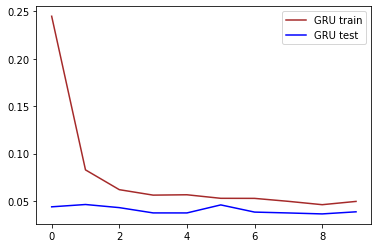

In [23]:
plt.plot(gru_history.history['loss'], label='GRU train', color='brown')
plt.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
plt.legend()
plt.show()

# Evaluate LSTM model

In [24]:
# predict LSTM model
pred = model_lstm.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

#Perform inverse transformation to rescale back to original range
#Since we used 8 variables for transform, the inverse expects same dimensions
# Invert scaling for forecast
inv_pred = concatenate((pred, X_test[:, 1:]), axis=1)
y_pred = scaler.inverse_transform(inv_pred)[:,0]

# Invert scaling for actual
Y_test = Y_test.reshape((len(Y_test), 1))
inv_y_actual = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y_actual = scaler.inverse_transform(inv_y_actual)[:, 0]

In [25]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_actual, y_pred))
print('Test RMSE {}'.format(rmse))

Test RMSE 37.02802267054811
